In [1]:
# type: ignore
from dataclasses import dataclass
from pathlib import Path

import h5py
import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import pytest
import os
import gpflow

import hermes

np.random.seed(42)
tf.random.set_seed(42)

SIM_LOAD_DIR = Path("").absolute().joinpath("resources")
WAFER_COORDS_FILE = "XY_Coordinates_177.txt"
WAFER_COMPOSITION_FILE = "CombiView_Format_GeSbTe_Composition.txt"
WAFER_XRD_FILE = (
    "GeSbTe_XRD_MetaStable_Background subtracted and with normalization.txt"
)

instrument = hermes.instruments.CHESSQM2Beamline(
    simulation=True,
    wafer_directory=SIM_LOAD_DIR,
    wafer_coords_file=WAFER_COORDS_FILE,
    wafer_composition_file=WAFER_COMPOSITION_FILE,
    wafer_xrd_file=WAFER_XRD_FILE,
    sample_name="This is a great name",
)

2023-12-01 11:55:11.345417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 11:55:11.369938: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 11:55:11.369959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 11:55:11.369975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 11:55:11.374361: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-01 11:55:11.374973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [2]:
@dataclass
class RandomStart:
    domain: np.ndarray
    start_measurements: int

    def initialize(self):
        indexes = np.arange(0, self.domain.shape[0])
        permute = np.random.permutation(indexes)

        next_indexes = permute[0 : self.start_measurements]

        return next_indexes

In [3]:

domain_2d = instrument.composition_domain_2d
domain_3d = instrument.composition_domain[1]
start_measurements = 11
initialization_method = RandomStart(instrument.composition_domain_2d, start_measurements)
next_indexes = initialization_method.initialize()
next_locations = domain_2d[next_indexes]
domain = instrument.xy_locations.to_numpy()
# Get the indexes in the domain:
indexes = np.arange(0, domain.shape[0])

# Initialize containers for locations and measurements:
locations = np.array([]).reshape(-1, domain_2d.shape[1])
measurements = np.array([]).reshape(-1, instrument.sim_two_theta_space.shape[0])
next_measurements = instrument.move_and_measure(domain_3d[next_indexes])

locations = np.append(locations, next_locations, axis=0)
measurements = np.append(measurements, next_measurements, axis=0)

cluster_method = hermes.clustering.RBPots(
    measurements=measurements,
    measurements_distance_type=hermes.distance.CosineDistance(),
    measurements_similarity_type=hermes.similarity.SquaredExponential(lengthscale=0.1),
    locations=locations,
    resolution=0.2,
)
# cluster_method.form_graph()
cluster_method.cluster()
cluster_method.get_local_membership_prob()

# TODO use qm2 example

classification_method = hermes.classification.HeteroscedasticGPC(
    locations=locations,
    labels=cluster_method.labels,
    domain=domain,
    probabilities=cluster_method.probabilities,
    measured_indexes=indexes,
    indexes=indexes,
)

In [4]:
classification_method.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[0., 0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[1., 0., 0...."


In [5]:
classification_method.train()

In [6]:
classification_method.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17908
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[-0.37781, -0.22536, 0.60355..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[4.0220e-01, 0.0000e+00, 0.0000e+00..."


In [7]:
classification_method._likelihood

name,class,transform,prior,trainable,shape,dtype,value
HeteroscedasticMultiClass.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001


In [8]:
m = classification_method.model
m.kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,0
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,0.17908


In [9]:
classification_method.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17908
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[-0.37781, -0.22536, 0.60355..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[4.0220e-01, 0.0000e+00, 0.0000e+00..."


In [ ]:
classification_method.save_trained("trained1.hdf5")

In [5]:
HeteroscedasticGPC = hermes.classification.HeteroscedasticGPC

In [6]:
HeteroscedasticGPC.load("mytestfile.hdf5")

OSError: Unable to open file (truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048)

In [45]:
classification_method._likelihood

name,class,transform,prior,trainable,shape,dtype,value
HeteroscedasticMultiClass.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001


In [43]:
new_model = hermes.classification.HeteroscedasticGPC(
    locations=locations,
    labels=cluster_method.labels,
    domain=domain,
    probabilities=cluster_method.lengthscales,
    measured_indexes=indexes,
    indexes=indexes,
)


In [44]:
new_model.kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,0
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,0.17909


In [45]:
new_model.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17909
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[0., 0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[1., 0., 0...."


In [46]:
(new_model.kernel.__class__)

gpflow.kernels.stationaries.SquaredExponential

In [47]:
new_kernel = gpflow.kernels.Matern32(variance=1.0, lengthscales=1.0)

In [48]:
new_model.kernel = new_kernel

In [49]:
new_model.model.likelihood
# TODO likelihood?

name,class,transform,prior,trainable,shape,dtype,value
HeteroscedasticMultiClass.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001


In [50]:
new_model.kernel = gpflow.kernels.Matern12(variance=1.0, lengthscales=1.0)

In [51]:
new_model.model.kernel

name,class,transform,prior,trainable,shape,dtype,value
Matern12.variance,Parameter,Softplus,,True,(),float64,1
Matern12.lengthscales,Parameter,Softplus,,True,(),float64,1


In [52]:
new_model.load_params(classification_method.model)

In [53]:
new_model.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17909
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[-0.37791, -0.22552, 0.60329..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[4.0209e-01, 0.0000e+00, 0.0000e+00..."


In [54]:
new_model = hermes.classification.HeteroscedasticGPC(
    locations=locations,
    labels=cluster_method.labels,
    domain=domain,
    probabilities=cluster_method.probabilities,
    measured_indexes=indexes,
    indexes=indexes,
)


In [55]:
new_model.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17909
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[0., 0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[1., 0., 0...."


In [56]:

new_model.load_params(classification_method)

In [57]:
new_model.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17909
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[-0.37791, -0.22552, 0.60329..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[4.0209e-01, 0.0000e+00, 0.0000e+00..."


In [58]:
new_model.train()

In [59]:
new_model.model
# TODO not memory, disk

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17909
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[-0.37787, -0.2255, 0.60332..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[4.0210e-01, 0.0000e+00, 0.0000e+00..."


In [60]:
import tensorflow as tf
from typing import List, Optional, Tuple, Union, Callable

In [61]:
hasattr(classification_method.model, "compiled_predict_f")

False

In [62]:
domain.shape

(177, 2)

In [63]:
from typing import Any

In [64]:
# from https://gpflow.github.io/GPflow/2.9.0/notebooks/getting_started/saving_and_loading.html#TensorFlow-saved_model
classification_method.model.compiled_predict_f = tf.function(
    lambda Xnew: classification_method.model.predict_f(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None,domain.shape[1]], dtype=tf.float64)],
)
classification_method.model.compiled_predict_y = tf.function(
    lambda Xnew: classification_method.model.predict_y(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None,domain.shape[1]], dtype=tf.float64)],
)

In [65]:
tf.saved_model.save(classification_method.model, "saved_model_test_1")

INFO:tensorflow:Assets written to: saved_model_test_1/assets


INFO:tensorflow:Assets written to: saved_model_test_1/assets


In [66]:
load_test = tf.saved_model.load("saved_model_test_1")

In [67]:
classification_method.kernel #original

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,0
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,0.17909


In [68]:
classification_method.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17909
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[-0.37791, -0.22552, 0.60329..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[4.0209e-01, 0.0000e+00, 0.0000e+00..."


In [69]:
classification_method.save_params("testsaveparams.hdf5")

In [72]:
params = gpflow.utilities.parameter_dict(classification_method.model)

In [75]:
params[".q_mu"].__dict__

{'_name': 'identity',
 '_name_scope': <tensorflow.python.framework.ops.name_scope_v2 at 0x7fb6e86dae90>,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_pretransformed_input, ref=<tf.Variable 'Variable:0' shape=(11, 3) dtype=float64, numpy=
  array([[-0.37790632, -0.22552408,  0.60329451],
         [-0.14047989,  1.22893186, -1.08835296],
         [ 1.43953968, -0.73117933, -0.70836044],
         [-0.01447241, -0.75553498,  0.7700031 ],
         [ 0.84839044, -0.4330132 , -0.41537995],
         [ 1.39534271, -0.53269686, -0.86265958],
         [-0.28636256,  0.91992287, -0.63356556],
         [ 0.66961407, -0.37548424, -0.29413198],
         [-0.37980719,  0.67185821, -0.29203982],
         [ 0.23697101, -0.14658625, -0.09038897],
         [-0.24466712,  0.94638729, -0.70171586]])>),
  TrackableReference(name=_transform_fn, ref=tfp.bijectors.Identity("identity", batch_shape=[], min_event_ndims=0)),
  TrackableReference(name=_bi

In [42]:
keys = list(params.keys())

In [43]:
keys

['.kernel.variance',
 '.kernel.lengthscales',
 '.likelihood.invlink.epsilon',
 '.num_data',
 '.q_mu',
 '.q_sqrt']

In [74]:
f.create_dataset("kernel_variance", data=params[keys[0]])

<HDF5 dataset "kernel_variance": shape (), type "<f8">

In [75]:
f.create_dataset("kernel_lengthscales", data=params[keys[1]])

<HDF5 dataset "kernel_lengthscales": shape (), type "<f8">

In [76]:
f.create_dataset("epsilon", data=params[keys[2]])

<HDF5 dataset "epsilon": shape (), type "<f8">

In [77]:
f.create_dataset("num_data", data=params[keys[3]])

<HDF5 dataset "num_data": shape (), type "<i4">

In [78]:
f.create_dataset("q_mu", data=params[keys[4]])

<HDF5 dataset "q_mu": shape (11, 3), type "<f8">

In [79]:
f.create_dataset("q_sqrt", data=params[keys[5]])

<HDF5 dataset "q_sqrt": shape (3, 11, 11), type "<f8">

In [94]:
classification_method.model.kernel.__class__

gpflow.kernels.stationaries.SquaredExponential

In [88]:
f.get("kernel")[()]

b'SquaredExponential'

In [98]:
f.create_group("kernel")

<HDF5 group "/kernel" (0 members)>

In [99]:
f.create_dataset("kernel/variance", data=classification_method.model.kernel.variance)

<HDF5 dataset "variance": shape (), type "<f8">

In [100]:
f.create_dataset("kernel/lengthscales", data=classification_method.model.kernel.lengthscales)

<HDF5 dataset "lengthscales": shape (), type "<f8">

In [102]:
classification_method.model.kernel.__class__.__name__

'SquaredExponential'

In [103]:
f.create_dataset("kernel/name", data=classification_method.model.kernel.__class__.__name__)

<HDF5 dataset "name": shape (), type "|O">

In [104]:
f.close()

In [62]:
test = load_test.q_mu._pretransformed_input

In [38]:
testq = load_test.q_sqrt

In [71]:
s = testq._pretransformed_input.name.split(":")[0]

In [39]:
triang = tfp.math.fill_triangular(testq._pretransformed_input.numpy())

In [ ]:
tfp.bijectors.FillTriangular()

In [40]:
gpflow.base.Parameter(value=triang, transform=gpflow.utilities.triangular())

<Parameter: name=fill_triangular, dtype=float64, shape=[3, 11, 11], fn="fill_triangular", numpy=
array([[[ 4.02196142e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-3.52554867e-01,  6.07075190e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 4.11877934e-03, -7.50355823e-02,  6.02248886e-01,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.57246571e-01, -2.22264903e-01, -3.44871317e-02,
          6.25217283e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
       

In [41]:
gpflow.utilities.parameter_dict(classification_method.model)[".q_sqrt"]

<Parameter: name=fill_triangular, dtype=float64, shape=[3, 11, 11], fn="fill_triangular", numpy=
array([[[ 4.02196142e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-3.52554867e-01,  6.07075190e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 4.11877934e-03, -7.50355823e-02,  6.02248886e-01,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.57246571e-01, -2.22264903e-01, -3.44871317e-02,
          6.25217283e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
       

In [77]:
tfp.bijectors.FillTriangular

tensorflow_probability.python.bijectors.fill_triangular.FillTriangular

In [42]:
gpflow.utilities.parameter_dict(classification_method.model)[".num_data"]

<Parameter: name=identity, dtype=int32, shape=[], fn="identity", numpy=11>

In [43]:
gpflow.base.Parameter(value=load_test.num_data._pretransformed_input.numpy(), dtype=tf.int32)

<Parameter: name=identity, dtype=int32, shape=[], fn="identity", numpy=11>

In [44]:
gpflow.utilities.parameter_dict(classification_method.model)[".likelihood.invlink.epsilon"]

<Parameter: name=sigmoid, dtype=float64, shape=[], fn="sigmoid", numpy=0.0010000000000000002>

In [45]:
load_test.likelihood.invlink.epsilon._pretransformed_input

<tf.Variable 'sigmoid:0' shape=() dtype=float64, numpy=-6.906754778648553>

In [46]:
load_test.q_sqrt._pretransformed_input.shape

TensorShape([3, 66])

In [47]:
sig1 = tf.math.sigmoid(load_test.likelihood.invlink.epsilon._pretransformed_input.numpy())
sig1

<tf.Tensor: shape=(), dtype=float64, numpy=0.0010000000000000002>

In [48]:
gpflow.base.Parameter(value=sig1, transform=tfp.bijectors.Sigmoid())

<Parameter: name=sigmoid, dtype=float64, shape=[], fn="sigmoid", numpy=0.0010000000000000002>

In [49]:
load_test.kernel.variance._pretransformed_input

<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-12.468608288239908>

In [50]:
load_test.kernel.lengthscales._pretransformed_input

<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-1.6290125940203466>

In [51]:
kv = tf.math.softplus(load_test.kernel.variance._pretransformed_input)
kv

<tf.Tensor: shape=(), dtype=float64, numpy=3.845487361650802e-06>

In [52]:
ls = tf.math.softplus(load_test.kernel.lengthscales._pretransformed_input)
ls

<tf.Tensor: shape=(), dtype=float64, numpy=0.1790856031591021>

In [53]:
gpflow.base.Parameter(value=kv, transform=tfp.bijectors.Softplus())

<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=3.845487361650802e-06>

In [54]:
gpflow.base.Parameter(value=ls, transform=tfp.bijectors.Softplus())

<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.1790856031591021>

In [55]:
gpflow.utilities.parameter_dict(classification_method.model)[".kernel.lengthscales"]

<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.1790856031591021>

In [56]:
load_test.kernel.variance.__dict__

{'_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_pretransformed_input, ref=<tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-12.468608288239908>),
  TrackableReference(name=_transform_fn, ref=<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7fef4dd342e0>),
  TrackableReference(name=_bijector, ref=<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7fef4dd342e0>),
  TrackableReference(name=_self_saveable_object_factories, ref={})],
 '_self_unconditional_dependency_names': {'_pretransformed_input': <tf.Variable 'softplus:0' shape=() dtype=float64, numpy=-12.468608288239908>,
  '_transform_fn': <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fef4dd342e0>,
  '_bijector': <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fef4dd34

In [57]:
classification_method.model.kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,0
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,0.17909


In [50]:
mean1, var1 = classification_method.model.predict_y(domain)

In [52]:
from matplotlib import pyplot as plt

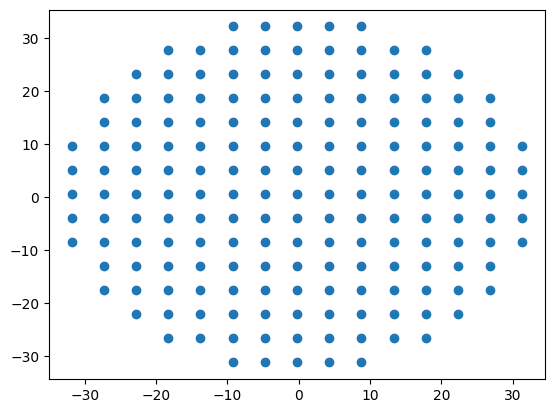

In [53]:
plt.scatter(domain[:,0], domain[:,1])

In [54]:
classification_method.predict()

In [55]:
classification_method.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17909
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[-0.3779, -0.22553, 0.60329..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[4.0208e-01, 0.0000e+00, 0.0000e+00..."


In [56]:
c = np.zeros((172,2))*np.NaN
n = domain[0:5,:]
s = np.concatenate((n,c), axis=0)

In [57]:
mean1, var1 = classification_method.model.predict_y(s)

In [58]:
mean2, var2 = load_test.compiled_predict_y(n)

In [59]:
type(load_test.compiled_predict_y(n))

tuple

In [62]:
load_test.kernel

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f70d3eafe80>

In [36]:
np.sum(mean1 != mean2)

531

In [37]:
np.sum(mean1 == mean2)

0